In [2]:
library(exactRankTests)
library(nlme)
library(stats)
library(ggplot2)
library("phyloseq")
library(tidyverse)

In [2]:
ancom.W = function(otu_data,var_data,
                   adjusted,repeated,
                   main.var,adj.formula,
                   repeat.var,long,rand.formula,
                   multcorr,sig){
  
  n_otu=dim(otu_data)[2]-1
  
  otu_ids=colnames(otu_data)[-1]
  
  if(repeated==F){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID",all.y=T),row.names=NULL)
    #data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var)],by="Sample.ID",all.y=T),row.names=NULL)
  }else if(repeated==T){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID"),row.names=NULL)
    # data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var,repeat.var)],by="Sample.ID"),row.names=NULL)
  }
  
  base.formula = paste0("lr ~ ",main.var)
  if(repeated==T){
    repeat.formula = paste0(base.formula," | ", repeat.var)
  }
  if(adjusted==T){
    adjusted.formula = paste0(base.formula," + ", adj.formula)
  }
  
  if( adjusted == F & repeated == F ){
    fformula  <- formula(base.formula)
  } else if( adjusted == F & repeated == T & long == T ){
    fformula  <- formula(base.formula)   
  }else if( adjusted == F & repeated == T & long == F ){
    fformula  <- formula(repeat.formula)   
  }else if( adjusted == T & repeated == F  ){
    fformula  <- formula(adjusted.formula)   
  }else if( adjusted == T & repeated == T  ){
    fformula  <- formula(adjusted.formula)   
  }else{
    stop("Problem with data. Dataset should contain OTU abundances, groups, 
         and optionally an ID for repeated measures.")
  }
  
  
  
  if( repeated==FALSE & adjusted == FALSE){
    if( length(unique(data_comp[,which(colnames(data_comp)==main.var)]))==2 ){
      tfun <- exactRankTests::wilcox.exact
    } else{
      tfun <- stats::kruskal.test
    }
  }else if( repeated==FALSE & adjusted == TRUE){
    tfun <- stats::aov
  }else if( repeated== TRUE & adjusted == FALSE & long == FALSE){
    tfun <- stats::friedman.test
  }else if( repeated== TRUE & adjusted == FALSE & long == TRUE){
    tfun <- nlme::lme
  }else if( repeated== TRUE & adjusted == TRUE){
    tfun <- nlme::lme
  }
  
  logratio.mat <- matrix(NA, nrow=n_otu, ncol=n_otu)
  for(ii in 1:(n_otu-1)){
    for(jj in (ii+1):n_otu){
      data.pair <- data_comp[,which(colnames(data_comp)%in%otu_ids[c(ii,jj)])]
      lr <- log((1+as.numeric(data.pair[,1]))/(1+as.numeric(data.pair[,2])))
      
      lr_dat <- data.frame( lr=lr, data_comp,row.names=NULL )
      
      if(adjusted==FALSE&repeated==FALSE){  ## Wilcox, Kruskal Wallis
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==FALSE&repeated==TRUE&long==FALSE){ ## Friedman's 
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==TRUE&repeated==FALSE){ ## ANOVA
        model=tfun(formula=fformula, data = lr_dat,na.action=na.omit)   
        picker=which(gsub(" ","",row.names(summary(model)[[1]]))==main.var)  
        logratio.mat[ii,jj] <- summary(model)[[1]][["Pr(>F)"]][picker]
      }else if(repeated==TRUE&long==TRUE){ ## GEE
        model=tfun(fixed=fformula,data = lr_dat,
                   random = formula(rand.formula),
                   correlation=corAR1(),
                   na.action=na.omit)   
        picker=which(gsub(" ","",row.names(anova(model)))==main.var)
        logratio.mat[ii,jj] <- anova(model)[["p-value"]][picker]
      }
      
    }
  } 
  
  ind <- lower.tri(logratio.mat)
  logratio.mat[ind] <- t(logratio.mat)[ind]
  
  
  logratio.mat[which(is.finite(logratio.mat)==FALSE)] <- 1
  
  mc.pval <- t(apply(logratio.mat,1,function(x){
    s <- p.adjust(x, method = "BH")
    return(s)
  }))
  
  a <- logratio.mat[upper.tri(logratio.mat,diag=FALSE)==TRUE]
  
  b <- matrix(0,ncol=n_otu,nrow=n_otu)
  b[upper.tri(b)==T] <- p.adjust(a, method = "BH")
  diag(b)  <- NA
  ind.1    <- lower.tri(b)
  b[ind.1] <- t(b)[ind.1]
  
  #########################################
  ### Code to extract surrogate p-value
  surr.pval <- apply(mc.pval,1,function(x){
    s0=quantile(x[which(as.numeric(as.character(x))<sig)],0.95)
    # s0=max(x[which(as.numeric(as.character(x))<alpha)])
    return(s0)
  })
  #########################################
  ### Conservative
  if(multcorr==1){
    W <- apply(b,1,function(x){
      subp <- length(which(x<sig))
    })
    ### Moderate
  } else if(multcorr==2){
    W <- apply(mc.pval,1,function(x){
      subp <- length(which(x<sig))
    })
    ### No correction
  } else if(multcorr==3){
    W <- apply(logratio.mat,1,function(x){
      subp <- length(which(x<sig))
    })
  }
  
  return(W)
  }




ANCOM.main = function(OTUdat,Vardat,
                      adjusted,repeated,
                      main.var,adj.formula,
                      repeat.var,longitudinal,
                      random.formula,
                      multcorr,sig,
                      prev.cut){
  
  p.zeroes=apply(OTUdat[,-1],2,function(x){
    s=length(which(x==0))/length(x)
  })
  
  zeroes.dist=data.frame(colnames(OTUdat)[-1],p.zeroes,row.names=NULL)
  colnames(zeroes.dist)=c("Taxon","Proportion_zero")
  
  zero.plot = ggplot(zeroes.dist, aes(x=Proportion_zero)) + 
    geom_histogram(binwidth=0.1,colour="black",fill="white") + 
    xlab("Proportion of zeroes") + ylab("Number of taxa") +
    theme_bw()
  
  #print(zero.plot)
  
  OTUdat.thinned=OTUdat
  OTUdat.thinned=OTUdat.thinned[,c(1,1+which(p.zeroes<prev.cut))]
  
  otu.names=colnames(OTUdat.thinned)[-1]
  
  W.detected   <- ancom.W(OTUdat.thinned,Vardat,
                          adjusted,repeated,
                          main.var,adj.formula,
                          repeat.var,longitudinal,random.formula,
                          multcorr,sig)
  
  W_stat       <- W.detected
  
  
  ### Bubble plot
  
  W_frame = data.frame(otu.names,W_stat,row.names=NULL)
  W_frame = W_frame[order(-W_frame$W_stat),]
  
  W_frame$detected_0.9=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.8=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.7=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.6=rep(FALSE,dim(W_frame)[1])
  
  W_frame$detected_0.9[which(W_frame$W_stat>0.9*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.8[which(W_frame$W_stat>0.8*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.7[which(W_frame$W_stat>0.7*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.6[which(W_frame$W_stat>0.6*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  
  final_results=list(W_frame,zero.plot)
  names(final_results)=c("W.taxa","PLot.zeroes")
  return(final_results)
}

In [29]:
map1 <- read.table(file = "/Users/stephanie.rosales/Documents/omics_projects/NutrientsAC16S/2019_Acer_nutrients/AcNutrients/Nutrient_16s_Metadata.txt",
                  
                header=TRUE)
colnames(map1) [1] = "Sample.ID"
head(map1)

SV <- read.table("/Users/stephanie.rosales/Documents/omics_projects/NutrientsAC16S/2019_Acer_nutrients/ANCOM_tables/ps_df.txt",
                    header = TRUE)
colnames(SV) [1] = "Sample.ID"
head(SV)
dim(SV)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”


,Sample.ID,frag_ID,former.id,EuC1,EuC2,Richness,error,lower,upper,Bcode,⋯,Date_DNA,dBW_g,Date_BW,Chl_a,Chl_a_mean,Sym_cm2,Sym_cm2_mean,Date.Blastate,Days_Experiment,Days_Survivor
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>
1,AC149JanuaryO,149_AC,149-January-O,0.030111428,-0.06890866,16.14326,0.3947832,16.02666,16.76997,515rcbc56,⋯,1/29/18,4.990424,1/29/18,4.12,4.120,3.198131,3.1981314,2/5/18,76,188
2,AC152FebruaryO,152_AC,152-February-O,-0.019906845,-0.02994868,56.17302,0.4221207,56.03326,56.90015,515rcbc103,⋯,2/23/18,1.941700,2/23/18,NA,NA,NA,NA,NAN,99,211
3,AC152JanuaryO,152_AC,152-January-O,0.043883164,-0.01715893,38.06265,0.2531004,38.01209,38.32456,515rcbc147,⋯,1/29/18,3.579989,1/29/18,NA,4.120,NA,3.1981314,NA,76,188
4,AC152MarchO,152_AC,152-March-O,-0.153760402,0.05213697,76.07085,0.2692248,76.01367,76.36716,515rcbc151,⋯,3/6/18,1.438800,3/8/18,NA,0.975,NA,0.5934423,NA,110,222
5,AC157FebruaryO,157_AC,157-February-O,0.004053245,-0.02239785,37.08197,0.2900262,37.01579,37.42556,515rcbc61,⋯,2/23/18,2.931600,2/23/18,NA,NA,NA,NA,NAN,99,211
6,AC157JanuaryO,157_AC,157-January-O,0.048683064,-0.01705265,40.10079,0.3218617,40.01940,40.52376,515rcbc133,⋯,1/29/18,4.220275,1/29/18,NA,4.120,NA,3.1981314,NA,76,188


,Sample.ID,a9287af133022dd3701716a5a6317aa0,X09559efaa02f2d1000b20616d6ac4c10,X7762a511e872899973349ab74d43bc70,X7d97cd0e6a94bd18332c7c28e89b1e3d,X82959c4005a0e10063a5669ce3357eeb,f4a7b2d9f3b129b8529c73e2c8c07789,c72fc57c2cbf233b1829c4f936113958,X3b2efcaa01e6473a8935cbb9c961cbb0,a615b3682482490f548d308929f9959c,⋯,f15ed42bebfc35cb7beb6b9c8674aaab,X162f7709d4e0b2467ba2320e311c3590,X954acff8abca56fce3c1a23bf0568fbe,db107b01bf64668a99d86cd69f74737b,X44fe7bf4c7cebfce1d21aa489869e46a,X8b189f887eba469df51738f5e4cb9e76,X4ceea551d8ae51beca6505410afc3202,X039449e16e8ce5a2b85b5ac7190e4530,X6081866d9ca51a5193045a0c31422988,X70a8212f699f200737f3a95fd35ae641
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AC101JanuaryRY,0,4270,0,0,0,9,0,5,0,⋯,15,0,2,0,0,0,0,0,0,0
2,AC102FebruaryRY,0,5614,3,3,0,0,0,0,0,⋯,85,0,0,0,0,0,49,0,0,0
3,AC102JanuaryRY,0,5603,0,0,0,0,0,0,0,⋯,603,0,0,0,0,0,31,0,0,0
4,AC102MarchRY,0,4948,0,0,0,0,0,0,0,⋯,0,0,0,9,0,0,0,0,0,0
5,AC103DecemberRY,2,2247,0,0,0,0,0,0,0,⋯,0,9,0,0,0,0,0,0,0,0
6,AC104JanuaryRY,0,9102,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 179 667

In [92]:
map2 = map1 %>%
filter (Days=="Day75")
dim(map2)


map_A75=  map1 %>%
filter(Treatment == "C", Days=="Day75")

map_nutrients_75= map1 %>%
filter(Days=="Day75")


heat_alldays= map1 %>%
filter (Treatment == "C")


genets=c("G_48", "G_62")
N_alldays= map1 %>%
filter(Treatment == "N", Genotype %in% genets)

dim(N_alldays)

genets=c("G_48", "G_62", "G_31")
NP_alldays= map1 %>%
filter(Treatment == "NP", Genotype %in% genets)

dim(NP_alldays)

[1] 90 60

[1] 27 60

[1] 42 60

In [90]:
SV_T = semi_join(SV, map2)  
dim(SV_F)

mapT = semi_join(map2, SV_F)
dim(map3)
head(map3)
dim(SV_F)

SV_G = semi_join(SV, map_A75)  
dim(SV_G)


mapG = semi_join(map2, SV_G)
dim(mapG)


SV_G = semi_join(SV, map_A75)  
dim(SV_G)


mapG = semi_join(map2, SV_G)
dim(mapG)



SV_H = semi_join(SV, heat_alldays)  
dim(SV_H)

mapH = semi_join(heat_alldays, SV_H)
dim(mapH)


SV_H = semi_join(SV, heat_alldays)  
dim(SV_H)

mapH = semi_join(heat_alldays, SV_H)
dim(mapH)



SV_N = semi_join(SV, N_alldays)  
dim(SV_N)

mapN = semi_join(N_alldays, SV_N)
dim(mapN)

SV_NP = semi_join(SV, NP_alldays)  
dim(SV_N)

mapNP = semi_join(NP_alldays, SV_NP)
dim(mapNP)


Joining, by = "Sample.ID"



[1]  85 667

Joining, by = "Sample.ID"



[1] 85 60

,Sample.ID,frag_ID,former.id,EuC1,EuC2,Richness,error,lower,upper,Bcode,⋯,Date_DNA,dBW_g,Date_BW,Chl_a,Chl_a_mean,Sym_cm2,Sym_cm2_mean,Date.Blastate,Days_Experiment,Days_Survivor
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>
1,AC149JanuaryO,149_AC,149-January-O,0.03011143,-0.068908657,16.14326,0.3947832,16.02666,16.76997,515rcbc56,⋯,1/29/18,4.990424,1/29/18,4.12,4.120,3.198131,3.198131,2/5/18,76,188
2,AC152JanuaryO,152_AC,152-January-O,0.04388316,-0.017158932,38.06265,0.2531004,38.01209,38.32456,515rcbc147,⋯,1/29/18,3.579989,1/29/18,NA,4.120,NA,3.198131,NA,76,188
3,AC157JanuaryO,157_AC,157-January-O,0.04868306,-0.017052649,40.10079,0.3218617,40.01940,40.52376,515rcbc133,⋯,1/29/18,4.220275,1/29/18,NA,4.120,NA,3.198131,NA,76,188
4,AC160JanuaryO,160_AC,160-January-O,0.05151658,-0.002903576,41.04864,0.2222339,41.00943,41.25095,515rcbc173,⋯,1/29/18,3.532928,1/29/18,NA,4.120,NA,3.198131,NA,76,188
5,AC248JanuaryO,248_AC,248-January-O,0.03962534,-0.050348297,26.18548,0.4429204,26.03509,26.98033,515rcbc97,⋯,1/29/18,4.414209,1/29/18,NA,4.120,NA,3.198131,NA,76,188
6,AC150JanuaryO,150_AC,150-January-O,0.03253863,-0.063921401,11.08151,0.2980281,11.01515,11.43850,515rcbc6,⋯,1/29/18,1.398238,1/29/18,NA,6.045,NA,4.555941,NA,76,188


[1]  85 667

Joining, by = "Sample.ID"



[1]  30 667

Joining, by = "Sample.ID"



[1] 30 60

Joining, by = "Sample.ID"



[1]  30 667

Joining, by = "Sample.ID"



[1] 30 60

Joining, by = "Sample.ID"



[1]  84 667

Joining, by = "Sample.ID"



[1] 84 60

Joining, by = "Sample.ID"



[1]  84 667

Joining, by = "Sample.ID"



[1] 84 60

Joining, by = "Sample.ID"



[1]  26 667

Joining, by = "Sample.ID"



[1] 26 60

Joining, by = "Sample.ID"



[1]  26 667

Joining, by = "Sample.ID"



[1] 41 60

In [88]:
dim(mapNP)

[1] 31 60

$W.taxa
                            otu.names W_stat detected_0.9 detected_0.8
48  X0172efa347740fe7d9cbd7dec793bd67    127        FALSE        FALSE
10  X2553dd8562ebd5234f3b3102efe6ac4e    105        FALSE        FALSE
18  X3f4bf28104659136bd4899d83721746a     95        FALSE        FALSE
121 X0214c0be2a25dc9832d1c3174f8e75d6     59        FALSE        FALSE
103  c931e7374bb9c1621b2401ec3c4f9dab     41        FALSE        FALSE
19   ea441a147e7bd6815155a64b4cf264e4     19        FALSE        FALSE
69  X8fd01a3ffeae72b757fa5370059cc8b2     11        FALSE        FALSE
49  X8cc15f7ae42da48a95d52fac614ae850      7        FALSE        FALSE
132 X1d5a70d4266ba1c3818b9b8c005ad050      7        FALSE        FALSE
98   b613f23a51b724f4dcbb199d0beb954c      6        FALSE        FALSE
37   b52e854d790095187cb2fb39ffd56b1f      3        FALSE        FALSE
127 X677cba3456c96ef91652d4d6026f8b2a      3        FALSE        FALSE
142  e84adbe590e5912141e7ef16e0a4402e      3        FALSE        FALS

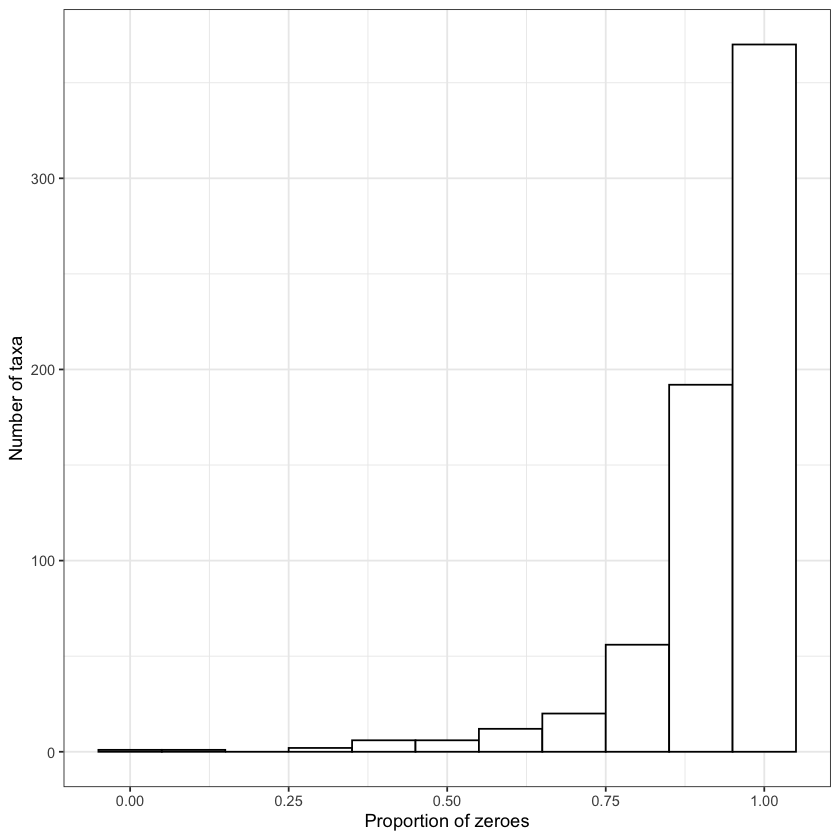

In [97]:
ANCOM.main(OTUdat = SV_T, 
         Vardat = mapT,
                            adjusted = T,
                            repeated = F,
                            main.var = "Treatment:Genotype",
                            adj.formula = "Genotype",
                            repeat.var = NULL,
                            longitudinal = F,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.90)

$W.taxa
                            otu.names W_stat detected_0.9 detected_0.8
1   X09559efaa02f2d1000b20616d6ac4c10    147         TRUE         TRUE
8   X27a90a5f695f8bccb3d1f1f03cbefe00    147         TRUE         TRUE
21  X2a9757272d74d9dceac1fc00fdf9933b    147         TRUE         TRUE
46   cb94d54fbd46f4c7381e484a3ec93f1b    147         TRUE         TRUE
63   f5ab5cdbed22b56e99c06911e9efc981    147         TRUE         TRUE
71   abdc7d8d141a18a596ce062c646adb9e    147         TRUE         TRUE
75   cd7d8e0f6af7697da215d2340024323e    147         TRUE         TRUE
78  X191a8648d18fce54066bdddd85bded65    147         TRUE         TRUE
142 X9a30c1aa2ef737f5edfebebb81e895f4    147         TRUE         TRUE
61   f42edecaeb12b5bc32ce723fdb237685    146         TRUE         TRUE
93  X3427e4c74f6ce96417c4f2c6295a0c03    146         TRUE         TRUE
41  X118569d5769c8f5e135983de4f8b8de6    145         TRUE         TRUE
59  X066b4bd4d22be208c993dad82aa18cfb    145         TRUE         TRU

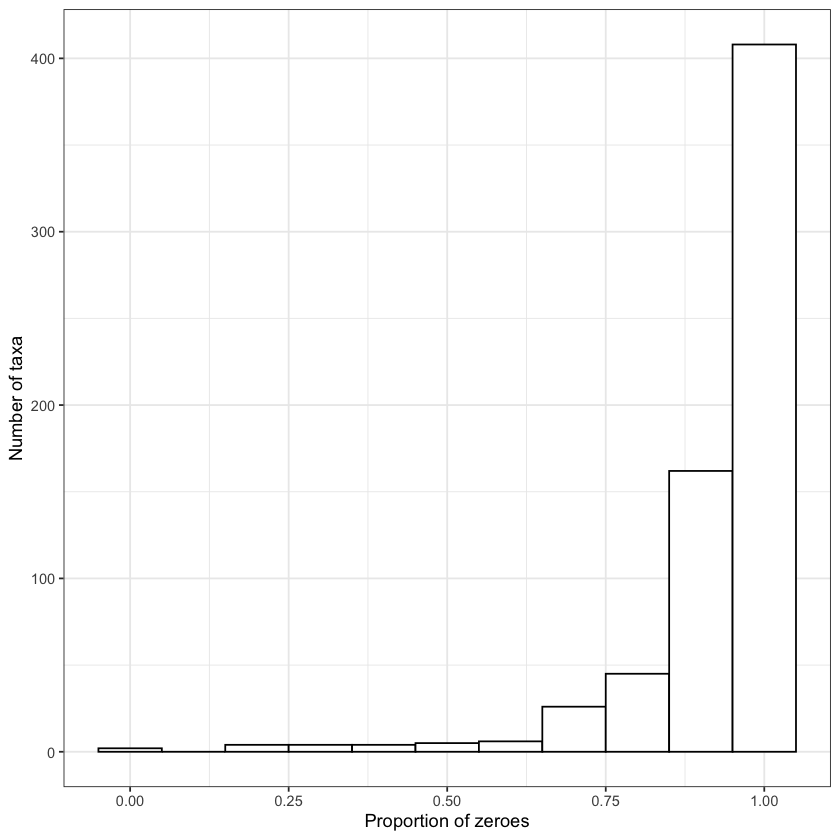

In [98]:
 ANCOM.main(OTUdat = SV_H, 
         Vardat = mapH,
                            adjusted = T,
                            repeated = F,
                            main.var = "TimePoint:Genotype",
                            adj.formula = F,
                            repeat.var = T,
                            longitudinal = T,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.90)

$W.taxa
                            otu.names W_stat detected_0.9 detected_0.8
1   X09559efaa02f2d1000b20616d6ac4c10    181         TRUE         TRUE
41  X16c7f9c9d5e489a603191d407d51f4db    180         TRUE         TRUE
98  X2ca4167f4fc7c9da0cb4c7e9736588cc    179         TRUE         TRUE
7    bdc3e6ffc0239a40200bf7c3f088cd34    178         TRUE         TRUE
51   cb94d54fbd46f4c7381e484a3ec93f1b    178         TRUE         TRUE
76   f5ab5cdbed22b56e99c06911e9efc981    178         TRUE         TRUE
177 X9a30c1aa2ef737f5edfebebb81e895f4    176         TRUE         TRUE
99  X970424b92e1dc6cfc7abb159d01fb8d7    172         TRUE         TRUE
104  b8ebe7fb1dc5cc83be900438b75086b1    166         TRUE         TRUE
45  X118569d5769c8f5e135983de4f8b8de6    165         TRUE         TRUE
53   d6a83f0bc2edfc999e010a189b3a7403    165         TRUE         TRUE
108  e853f94b05c9ff42fbe5a386387634ef    162        FALSE         TRUE
80   c18bbd597d0f8958d141dc36d983bb6a    159        FALSE         TRU

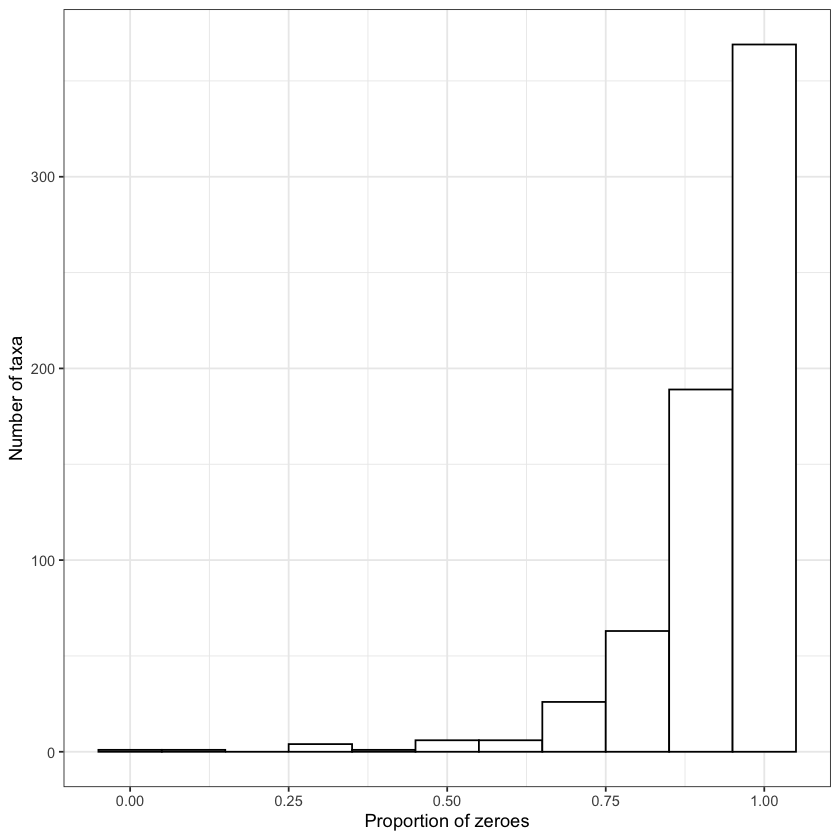

In [99]:
 ANCOM.main(OTUdat = SV_N, 
         Vardat = mapN,
                            adjusted = T,
                            repeated = F,
                            main.var = "TimePoint:Genotype",
                            adj.formula = F,
                            repeat.var = T,
                            longitudinal = T,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.90)

$W.taxa
                            otu.names W_stat detected_0.9 detected_0.8
1   X09559efaa02f2d1000b20616d6ac4c10    132         TRUE         TRUE
15  X2a9757272d74d9dceac1fc00fdf9933b    132         TRUE         TRUE
56   abdc7d8d141a18a596ce062c646adb9e    129         TRUE         TRUE
32   cb94d54fbd46f4c7381e484a3ec93f1b    128         TRUE         TRUE
8   X2553dd8562ebd5234f3b3102efe6ac4e    127         TRUE         TRUE
129 X9a30c1aa2ef737f5edfebebb81e895f4    127         TRUE         TRUE
25  X16c7f9c9d5e489a603191d407d51f4db    126         TRUE         TRUE
48   f5ab5cdbed22b56e99c06911e9efc981    126         TRUE         TRUE
38  X0172efa347740fe7d9cbd7dec793bd67    125         TRUE         TRUE
36  X26a78ca47dd81e8a4ad8e26bc78a2106    124         TRUE         TRUE
7    bcc8c2a040693c9809ec0e98bb6e56c8    122         TRUE         TRUE
4   X18544a615adb7bc24208a9413cf1bbe6    121         TRUE         TRUE
6    bdc3e6ffc0239a40200bf7c3f088cd34    121         TRUE         TRU

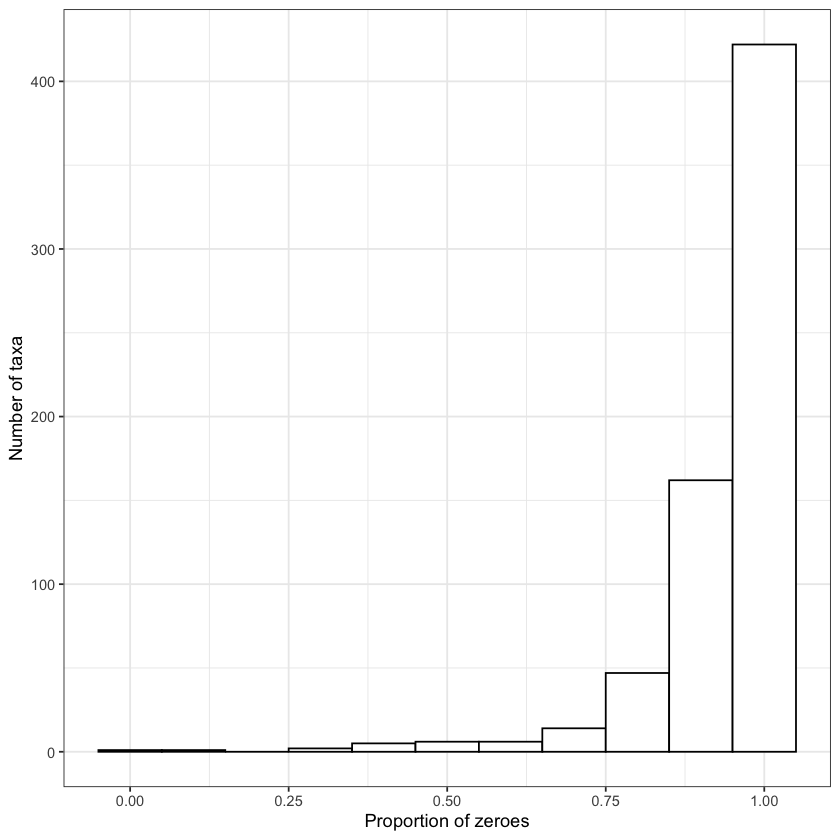

In [100]:
 ANCOM.main(OTUdat = SV_NP, 
         Vardat = mapNP,
                            adjusted = T,
                            repeated = F,
                            main.var = "TimePoint:Genotype",
                            adj.formula = F,
                            repeat.var = T,
                            longitudinal = T,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.90)

$W.taxa
                            otu.names W_stat detected_0.9 detected_0.8
1   X09559efaa02f2d1000b20616d6ac4c10    139         TRUE         TRUE
22  X2a9757272d74d9dceac1fc00fdf9933b    134         TRUE         TRUE
89   c70578ea5c6a116e08d6c12308ba6b23     68        FALSE        FALSE
50  X8cc15f7ae42da48a95d52fac614ae850     54        FALSE        FALSE
88   cecf76fe52ff99f1cfbfd8f04a257b8c     31        FALSE        FALSE
97  X44c4e4aff91ab67f3b70ca51e4ed1b8b      2        FALSE        FALSE
39   fafa0803700ee72ccc23750b0fce9859      1        FALSE        FALSE
71  X2965b3fd8649a4953a8a28a104f3ee6e      1        FALSE        FALSE
74   e896203af97d7b16db8f7c886871138b      1        FALSE        FALSE
96   e853f94b05c9ff42fbe5a386387634ef      1        FALSE        FALSE
113 X677cba3456c96ef91652d4d6026f8b2a      1        FALSE        FALSE
116  fbef9e6e2ec84df8b775d03844b20a36      1        FALSE        FALSE
121 X2bb74b598c6e7a2e8527d46d3dfbd24c      1        FALSE        FALS

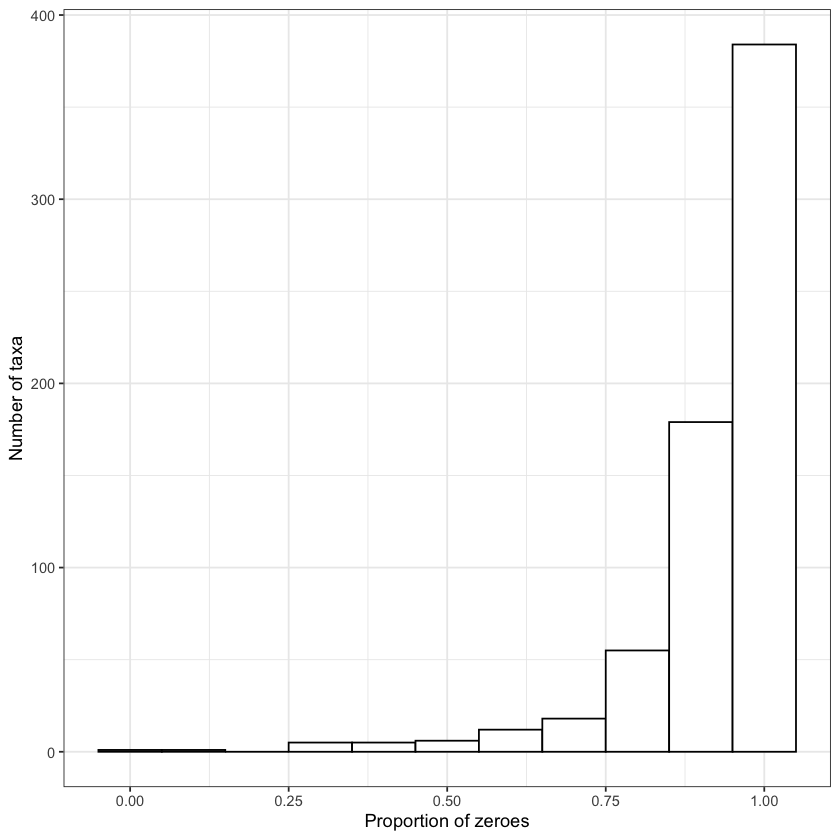

In [63]:
ANCOM.main(OTUdat = SV_G, 
         Vardat = mapG,
                            adjusted = F,
                            repeated = F,
                              main.var = "Genotype",
                            adj.formula = NULL,
                            repeat.var = NULL,
                            longitudinal = F,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.90)

$W.taxa
                           otu.names W_stat detected_0.9 detected_0.8
1  X09559efaa02f2d1000b20616d6ac4c10     34         TRUE         TRUE
6  X2a9757272d74d9dceac1fc00fdf9933b     34         TRUE         TRUE
11 X0317b291a55545f8f7e872ca7fed8523     10        FALSE        FALSE
26 X3e44de5cc821ee0fd83d438295743058      4        FALSE        FALSE
3  X18544a615adb7bc24208a9413cf1bbe6      3        FALSE        FALSE
13  b52e854d790095187cb2fb39ffd56b1f      3        FALSE        FALSE
19  f5ab5cdbed22b56e99c06911e9efc981      3        FALSE        FALSE
25  b613f23a51b724f4dcbb199d0beb954c      3        FALSE        FALSE
2  X752e0ab2bfe7a547641fd53ccc5534f7      2        FALSE        FALSE
5  X2553dd8562ebd5234f3b3102efe6ac4e      2        FALSE        FALSE
7   aef09777406791291aa8a8f4b1b8994e      2        FALSE        FALSE
8  X5e41ce9c7b1e617164ff8e21cb60ca1b      2        FALSE        FALSE
9  X16c7f9c9d5e489a603191d407d51f4db      2        FALSE        FALSE
10 X8f8aac1f

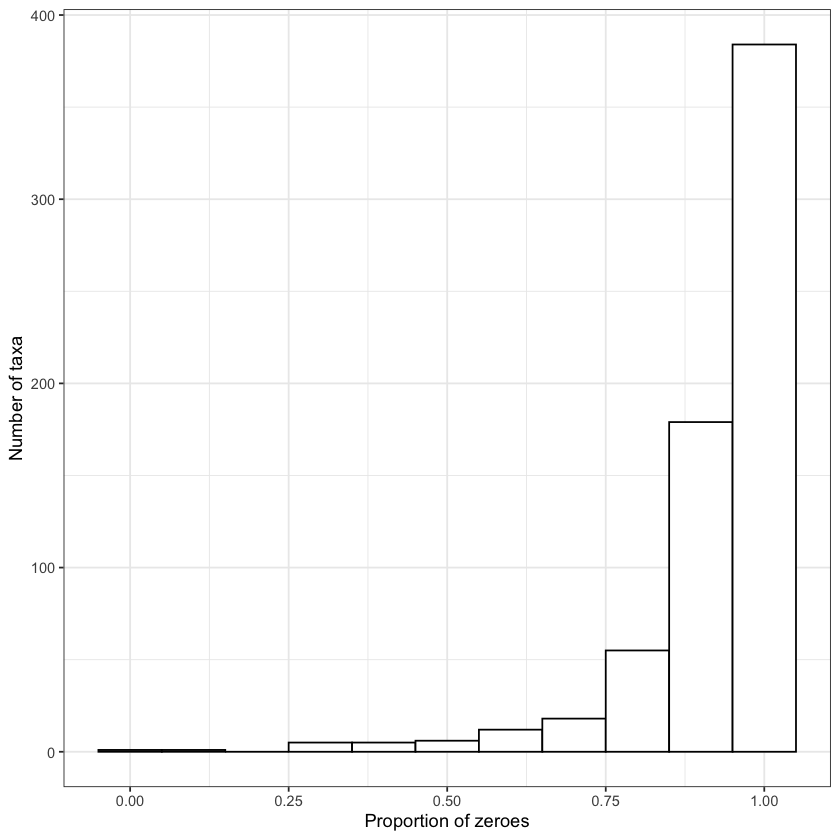

In [64]:
ANCOM.main(OTUdat = SV_G, 
         Vardat = mapG,
                            adjusted = T,
                            repeated = F,
                              main.var = "Surivor_110",
                            adj.formula = "Genotype",
                            repeat.var = NULL,
                            longitudinal = F,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.70)

$W.taxa
                            otu.names W_stat detected_0.9 detected_0.8
22  X2a9757272d74d9dceac1fc00fdf9933b    144        FALSE         TRUE
121 X0214c0be2a25dc9832d1c3174f8e75d6     84        FALSE        FALSE
23  X74347022edee7510ce46a2538b9d8033      1        FALSE        FALSE
42   cb94d54fbd46f4c7381e484a3ec93f1b      1        FALSE        FALSE
50  X0e3e02fac4685d88b3cdf5010081a5b6      1        FALSE        FALSE
60   a67f942fc3dc5f6dd9b8a2c7c9270ead      1        FALSE        FALSE
61  X033812d05209b433cbac80698ace9f66      1        FALSE        FALSE
62   f42edecaeb12b5bc32ce723fdb237685      1        FALSE        FALSE
71  X87f2ceaadbb12945aedf5ba5bb7e7b09      1        FALSE        FALSE
72  X8c4829c258c7721d564ac710412be95d      1        FALSE        FALSE
79  X912b51b00a56b37f4e8e7c9346120695      1        FALSE        FALSE
84  X6f119d883442b772367c80eac5e06f2c      1        FALSE        FALSE
89   c784c94b382cd4420c7ab7755c20a6f5      1        FALSE        FALS

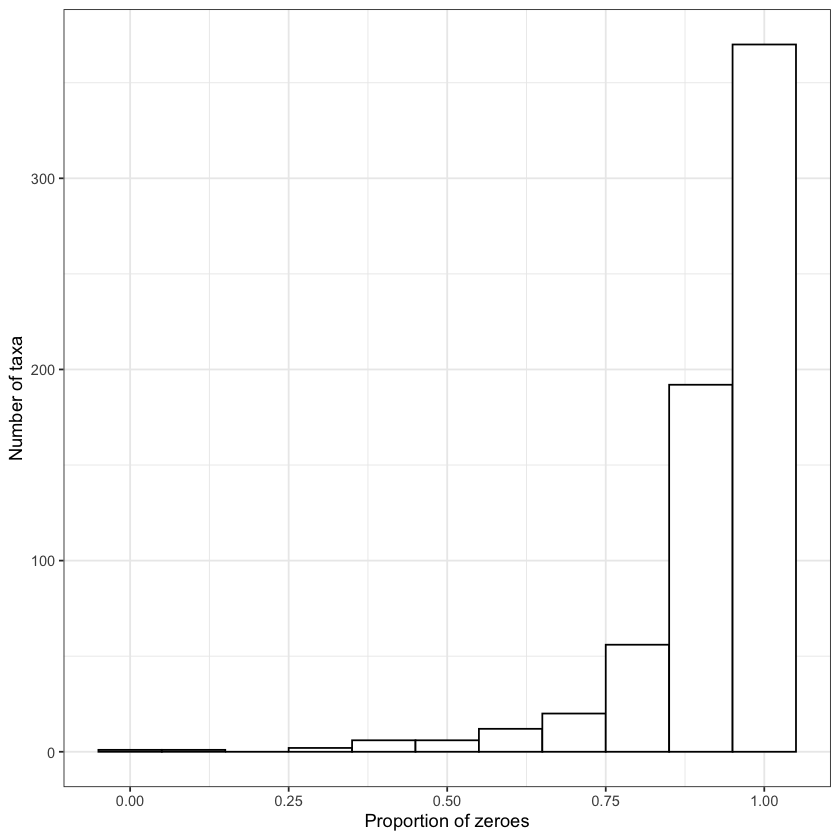

In [80]:
ANCOM.main(OTUdat = SV_T, 
         Vardat = mapT,
                            adjusted = T,
                            repeated = F,
                            main.var = "S_H",
                            adj.formula = "Genotype",
                            repeat.var = NULL,
                            longitudinal = F,
                            random.formula = "~1|:frag_ID",
                            multcorr = 2,
                            sig=0.05,
                            prev.cut = 0.90)